Телеграм бот для классификации спамных сообщений
---

На основе ноутубука nlp лекции № 6.

In [112]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re
import pandas as pd
import numpy as np
import string
#!pip install wordcloud
#from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words
from string import punctuation

In [95]:
# show all cell content
pd.set_option('display.max_colwidth', None)

In [15]:
#nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [17]:
#nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [7]:
# путь к данным
path = '../../data/spam_detection/'

In [76]:
# загружаем
df = pd.read_pickle(os.path.join(path, 'df.pkl'))
print(df.shape)
df

(18393, 2)


,msg,spam
0,Че за возня опять? Возле верного,0
1,Что то похожее на стрельбу было и сейчас три м...,0
2,А кто-то в курсе что за стрельба?,0
3,"Предупредительный был, видимо , от ментов",0
4,Всё закончилось. Разборки были с поножовщиной,0
...,...,...
18388,"Всем привет, никто не желает учить китайский я...",1
18389,Уважаемые родители ❗️❗️❗️\nХочу предложить Вам...,1
18390,"Добрый вечер,могу вам помочь с селективной пар...",1
18391,"Здравствуйте, есть один билет на концерт Серге...",1


## Предобработка текста

In [23]:
exclude = set(punctuation)
sw = set(get_stop_words("ru"))
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in exclude]
    return " ".join(txt)

df['msg'] = df['msg'].apply(preprocess_text)

In [24]:
df

,msg,spam
0,че за возня опять возле верный,0
1,что то похожий на стрельба быть и сейчас три м...,0
2,а ктоть в курс что за стрельба,0
3,предупредительный быть видимо от мент,0
4,всё закончиться разборка быть с поножовщина,0
...,...,...
18388,весь привет никтоня желать учить китайский язы...,1
18389,уважаемый родитель ❗️❗️❗️ хотеть предложить вы...,1
18390,добрый вечермочь вы помочь с селективный парфю...,1
18391,здравствуйте есть один билет на концерт сергей...,1


In [26]:
df['spam'].value_counts()

0    18047
1      346
Name: spam, dtype: int64

In [27]:
# дисбаланс классов
df.spam.value_counts()[1] / df.shape[0]

0.018811504376665036

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df['msg'], df['spam'],
                                                    test_size=0.2,
                                                    random_state=13,
                                                    stratify=df['spam']
                                                   )

Подберём наилучшее количество фичей в выходной матрице.

In [66]:
df_score = pd.DataFrame(columns=['n_features', 'ROC_AUC'])
i = 0

for n in tqdm(np.arange(50, 5000, 20)):
    count_vect = HashingVectorizer(n_features=n).fit(X_train.values)

    xtrain = count_vect.transform(X_train)
    xtest = count_vect.transform(X_test)

    lr = linear_model.LogisticRegression(class_weight="balanced").fit(xtrain, y_train)
    score = roc_auc_score(y_test, lr.predict_proba(xtest)[:, 1])
    df_score.loc[i] = [n, score]
    i += 1

100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [01:13<00:00,  3.38it/s]


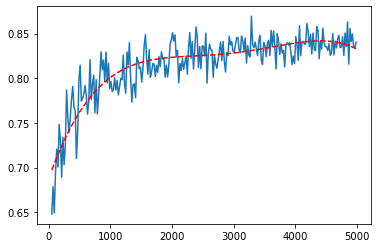

In [67]:
plt.plot(df_score['n_features'], df_score['ROC_AUC'])
z = np.polyfit(df_score['n_features'], df_score['ROC_AUC'], 4)
p = np.poly1d(z)
plt.plot(df_score['n_features'], p(df_score['n_features']),"r--")

plt.show()

In [71]:
df_score.tail(12)

,n_features,ROC_AUC
236,4770.0,0.846570
237,4790.0,0.825453
238,4810.0,0.850689
239,4830.0,0.835525
240,4850.0,0.863098
241,4870.0,0.815802
242,4890.0,0.855783
243,4910.0,0.841387
244,4930.0,0.849633
245,4950.0,0.834598


Выберем n_features = 4800 с ROC_AUC= 0.85 и переобучим модель

In [72]:
count_vect = HashingVectorizer(n_features=4800).fit(X_train.values)

xtrain = count_vect.transform(X_train)
xtest = count_vect.transform(X_test)

lr = linear_model.LogisticRegression(class_weight="balanced").fit(xtrain, y_train)
roc_auc_score(y_test, lr.predict_proba(xtest)[:, 1])

0.8499779196274438

In [69]:
roc_auc_score(y_test, lr.predict_proba(xtest)[:, 1])

0.8405997832108877

Проверим предсказания

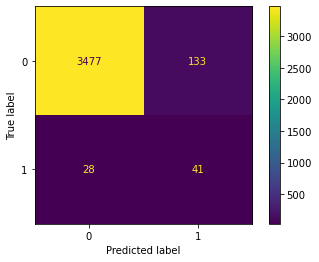

In [111]:
plot_confusion_matrix(lr, xtest, y_test)  
plt.show()  

In [113]:
compare_df = pd.DataFrame(X_test)
compare_df['predict'] = lr.predict_proba(xtest)[:, 1]
compare_df[compare_df['predict'] > 0.95]

,msg,predict
18088,❗️❗️❗️❗️❗️всем здравствуйте предоставление скидка до 50 в топ 15 страховой компаний❗️❗️❗️❗️м работать с весь страховой компания по прямой агентский договор специалист доставить документ бесплатно по москва и мо бесплатно провести осмотр как при оформление каско так и осаго оплата производиться после получение полис оплата наличнымикартойпо счёт мочь организовать вы оплата полис в офис страховой компания который вы выбрать ✅все вид страхование для физ и юр лицо ✅страхование автотранспорт ✅страхование квартира и загородный дом ✅дмс страхование отнесчастный случай в тот число для человек заниматься спорт ✅страхование для выезжать за рубеж и тд ✅предоставление скидка до 50 в топ 15 страховой компания ✅цена маленький дилер и агент ✅предоставление персональный менеджер на весь срок страхование а так же юридический поддержка на случай возникновение трение с страховой компания звонить либо писать алексей 89257294631,0.973221
18298,добрый день всем❗️❗️❗️❗️❗️предоставление скидка до 50 в топ 15 страховой компаний❗️❗️❗️❗️м работать с весь страховой компания по прямой агентский договор специалист доставить документ бесплатно по москва и мо бесплатно провести осмотр как при оформление каско так и осаго страхование такси грузовой автомобиль оплата производиться после получение полис оплата наличнымикартойпо счёт мочь организовать вы оплата полис в офис страховой компания который вы выбрать ✅все вид страхование для физ и юр лицо ✅страхование автотранспорт ✅страхование квартира и загородный дом ✅дмс страхование отнесчастный случай в тот число для человек заниматься спорт ✅страхование для выезжать за рубеж и тд ✅предоставление скидка до 50 в топ 15 страховой компания ✅цена маленький дилер и агент ✅предоставление персональный менеджер на весь срок страхование а так же юридический поддержка на случай возникновение трение с страховой компания алексей 89257294631,0.976083
18079,весь добрый вечер для новый студия растяжка в трц новоизмайловский инстаграмм tvorimtelom требоваться тренер и админ на вечерний часы если вы или ваш знакомый интересно писать в лс,0.977849
18157,❗️❗️❗️❗️❗️предоставление скидка до 50 в топ 15 страховой компаний❗️❗️❗️❗️м работать с весь страховой компания по прямой агентский договор специалист доставить документ бесплатно по москва и мо бесплатно провести осмотр как при оформление каско так и осаго оплата производиться после получение полис оплата наличнымикартойпо счёт мочь организовать вы оплата полис в офис страховой компания который вы выбрать ✅все вид страхование для физ и юр лицо ✅страхование автотранспорт ✅страхование квартира и загородный дом ✅дмс страхование отнесчастный случай в тот число для человек заниматься спорт ✅страхование для выезжать за рубеж и тд ✅предоставление скидка до 50 в топ 15 страховой компания ✅цена маленький дилер и агент ✅предоставление персональный менеджер на весь срок страхование а так же юридический поддержка на случай возникновение трение с страховой компания алексей 89257294631,0.967258
18294,добрый день 🙋zwj♂ у мы есть уникальный условие по покупка дверь от 2990 я являться дистрибьютор предоставлять оптоворозничный продажа на любой ваш потребность и пожелание предлагать вы лично удостовериться в соотношение ценакачество ожидать вы у мы в шоурум diamond doors 💎 мой контакт alexdoors16,0.956305
18105,пик аренда посредник при сдача квартира внаём в сейф ключ от хата чтобы квартира посмотреть облениться риелтор в квартира икамера понатыкать чтобы чегон спереть,0.954453
18067,добрый вечер весь участник группа снять жильё для семейный пара с два детьмиребёнок 10 и 13 год в новый измайлово,0.977756
18098,добрый вечер снять 1 комнатный квартира или студия,0.967362
4654,добрый вечер никтоня сдавать однокомнатный квартира или студия,0.972027
18072,добрый день снять 2к квартира в ваш жк семья из 4 человек 2 взрослый и 2 ребёнок школьник подробность в личный сообщение спасибо,0.960872
